# Heat transfer for pipes

In [328]:
"""
importing the necessary libraries, do not modify
"""
%matplotlib inline 


from IPython.display import clear_output

import schemdraw as schem
import schemdraw.elements as e

import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc

import sympy as sym



<img src="figures1/fig_08_08.jpg" alt="my awesome sketch" width=75% >
<i>Fig. 1: Illustration of internal convection.</i>

The above sketch illustrates the focus of this notebook: How to quantify the heat transfer between a pipe, in which a fluid flows, and its surroundings. The heat transfer from the outer surface of the pipe to the outer flow is to defined in the previous chapter, external convection. In the following, this notebook establishes the tools necessary to solve the internal convection problem.

## Entry flow and fully developed internal flow

<img src="figures1/fig_08_01.jpg" alt="my awesome sketch" width=100% >
<i>Fig. 2: Pipe flow nomenclature.</i>

### Python module

For internal flow, the module is loaded as:

In [329]:
from Libraries import HT_internal_convection as intconv


As an example, consider the flow of water in a pipe of diameter $D=10$ cm, length $L=10$m. The water thermodynamic properties are estimated at $T_f=50^\circ$C. The bulk velocity is $U_m=2$m/s.


In [330]:
from Libraries import thermodynamics as thermo
T_f = 50 #C
waterflow = thermo.Fluid('water',T_f,"C")

L_pipe = 10. #m
D_pipe = 0.1 #m
Um_pipe = 2 #m/s

In [331]:
?intconv.PipeFlow

In [332]:
pipe = intconv.PipeFlow(D= D_pipe, L=L_pipe,
                        rho=waterflow.rho, nu=waterflow.nu, Um=Um_pipe)

<img src="figures1/fig_08_03.jpg" alt="my awesome sketch" width=100% >
<i> Fig. 3. Friction factor in pipe flow as a function of Re and relative surface roughness.</i>

A uniform flow entering a pipe (Fig. 2) first experiences streamwise variation of velocity to accommodate the wall boundary conditions. A boundary layer, of thickness $\delta$, forms on the wall and grows until its edge reaches the pipe centerline. This region is the hydrodynamic entrance region. Beyond that point, the flow becomes fully developed, which means that
<ul>
<li> In the laminar regime, the velocity profile is only a function of $r$,</li>
<li> In the turbulent regime, the <b>mean</b> velocity profile is only a function of $r$.</li>
</ul>
Friction drag or the force exerted by the flow onto the pipe wall governs the pressure gradient necessary to generate a desired flowrate. Calculation of the friction drag leads to the design of the mechanical force creating the pressure gradient. In fully developed (laminar or turbulent) regimes, the pressure gradient may be determined by
<p class='alert alert-danger'>
$$
-\frac{\Delta\overline{P}}{L}=f\,\frac{1}{D}\,\frac{\rho U_m^2}{2}\;\;\;\;(\mathrm{Eq. 1})
$$
</p>
where $D=2R$ and $L$ are the diameter and length of the pipe, respectively, and $f$ is the <b>friction factor</b>. The bulk velocity or average velocity is
<p class='alert alert-info'>
$$
U_m=\frac{\dot{m}}{\rho A_c}\;\;\;\;(\mathrm{Eq. 2})
$$
</p>
where $\dot{m}$ is the mass flux
$$
\dot{m}=\int_0^{2\pi}\int_0^R\rho \overline{u}(r)\,r\,dr d\theta=2\pi\int_0^R\rho \overline{u}(r)\,r\,dr\;\;\;\;(\mathrm{Eq. 3})
$$
and $A_c=\pi R^2$
The Reynolds number of the flow is based on the bulk velocity and pipe diameter:
<p class='alert alert-danger'>
$$
Re_D=\frac{\rho U_mD}{\mu}=\frac{4\dot{m}}{\pi D\mu}\;\;\;\;(\mathrm{Eq. 4})
$$
</p>
The friction factor in the laminar regime is rigorously derived:
$$
f = \frac{64}{Re_D}\;\;\;\;(\mathrm{Eq. 5})
$$
</p>
and is valid up to the critical Reynolds number $Re_{D,c}$, which in most pipe is around 2,000. Be aware that in certain research facilities, the flow can remain laminar for Reynolds numbers up to 10,000. The Reynolds 2,000 is not absolute, universal property, but is the best guess from most engineering applications.

Beyond the critical Reynolds number, $f$ is a function of the roughness to diameter ratio $\varepsilon=e/D$ (e is typically the standard deviation of the roughness height) and the Reynolds number. A trustworthy empirical correlation is the Colebrook formula:
<p class='alert alert-danger'>
$$
\frac{1}{\sqrt{f}}=-2\log_{10}\left[\frac{\varepsilon}{3.7}+\frac{2.51}{Re_D\sqrt{f}}\right]\;\;\;\;(\mathrm{Eq. 6})
$$
</p>
which is solved below for a range of relative roughness $\varepsilon$.

Often there is a need to determine the pump or blower power $P$ necessary to move the flow at a prescribed pressure drop:
<p class='alert alert-danger'>
$$
P=\frac{\dot{m}}{\rho}\Delta p= \underbrace{(\Delta p)A_c}_\text{force}\cdot U_m\;\;\;\;(\mathrm{Eq. 7})
$$
</p>

### Example of functions
Going back to our library, let's explore how to determine some of the properties defined above:

Reynolds number:

In [333]:
print("Re= %1.2e" %pipe.Re)


Re= 3.61e+05


Mass flow rate:

In [334]:
print("mass flowrate= %1.1f kg/s" %pipe.mdot)

mass flowrate= 15.5 kg/s


Compute the friction factor:

In [335]:
pipe.f_turbulent()
# pipe.f_laminar()

Pipe wall is assumed to be hydrodynamically smooth


In [336]:
print("f= %1.5f" %pipe.f)

f= 0.01397


The mean pressure gradient is:

In [337]:
print("-dP/dx= %1.0f Pa/m" %pipe.dPdx)

-dP/dx= 2760 Pa/m


## Heat transfer by internal convection

The temperature is expected to vary both in the streamwise direction and in the radial direction. To reduce the complexity of the problem, we define the mean temperature as:
$$
T_m=\frac{1}{\dot{m}C_p}\int_{A_c}\rho\,u\,C_p\, T\,dA_c\;\;\;\;(\mathrm{Eq. 8})
$$
where $\dot{m}$ is the mass flow rate, $rho$ and $C_p$ are the density and specific heat of the fluid and $A_c$ is the cross-sectional area of the pipe.
### Overall energy balance

Applying the conservation of energy to a pipe flow, between its inlet and outlet, irrespective of its thermal boundary conditions at the wall or its flow condition (turbulent or laminar), yields the general equation for the convection heat rate between the fluid and the pipe's wall:

<p class='alert alert-danger'>
$$
q_\text{conv}=\dot{m}C_p(T_{m,o}-T_{m,i})\;\;\;\;(\mathrm{Eq. 9})
$$
</p>
This equation and others below, derived from this equation, is general and can be useful to design systems with target heat loss or gains. 

The local heat flux may be now expressed as:
$$
q_s''=h(T_s-T_m)\;\;\;\;(\mathrm{Eq. 10})
$$
where $h$ is the <b>local</b> convection heat transfer coefficient and $T_s$ is the surface temperature on the inner wall of the pipe. The variation of temperature in the <b>fully developed</b> flow can be shown to be governed by the following ODE:
<p class='alert alert-info'>
$$
\frac{dT_m}{dx}=\frac{P}{\dot{m}C_p}h(T_s-T_m)\;\;\;\;(\mathrm{Eq. 11})
$$
</p>
where $P$ is the perimeter of the pipe.
If the local heat flux is maintained constant over the length of the pipe $L$, the total heat rate is 
<p class='alert alert-danger'>
$$
q_\text{conv}=(PL)q_s''\, \text{$q_s''=$constant}\;\;\;\;(\mathrm{Eq. 2})
$$
</p>
and the streamwise distribution of the mean temperature is linear:
$$
T_m(x)=T_{m,i}+\frac{q_s''P}{\dot{m}C_p}x,\, \text{$q_s''=$constant}\;\;\;\;(\mathrm{Eq. 13})
$$
For the case of constant wall temperature $T_s$, the temperature distribution is the solution of the above ODE, thus of exponential nature. For practical applications, you most always need to compute the overall heat transfer and the outlet mean temperature $T_{m,o}$. The integration of the above ODE for $x=0$ to $x=L$ yields
<p class='alert alert-danger'>
$$
\frac{T_s-T_{m,o}}{T_s-T_{m,i}}=\exp\left(-\frac{PL}{\dot{m}C_p}\overline{h}\right),\, \text{$T_s=$constant}\;\;\;\;(\mathrm{Eq. 14})
$$
</p>
where 
<p class='alert alert-danger'>
$$
\overline{h}=\frac{1}{L}\int_0^L h(x)dx\;\;\;\;(\mathrm{Eq. 15})
$$
    </p>

If you must compute the mean temperature at $x$ an integration from $0$ to $x$ yields
<FONT FACE="courier" style="color:blue">T_mx_Ts_constant(T_s,T_mi,P,L,mdot,Cp,hbar,x)</FONT>
<p class='alert alert-danger'>
$$
\frac{T_s-T_{m}(x)}{T_s-T_{m,i}}=\exp\left(-\frac{Px}{\dot{m}C_p}\overline{h}_x\right),\, \text{$T_s=$constant}\;\;\;\;(\mathrm{Eq. 16})
$$
</p>
where 
$$
\overline{h}_x=\frac{1}{L}\int_0^x h(x')dx'\;\;\;\;(\mathrm{Eq. 17})
$$
The computation of the total heat transfer rate can be shown to write:
<p class='alert alert-danger'>
$$
q_\text{conv}=\overline{h}(PL)\Delta T_\text{lm},\, \text{$T_s=$constant}\;\;\;\;(\mathrm{Eq. 18})
$$
</p>
with the log mean temperature
<FONT FACE="courier" style="color:blue">log_mean_temperature(T_s,T_o,T_i)</FONT>
<p class='alert alert-danger'>
$$
\Delta T_\text{lm}=\cfrac{T_{m,i}-T_{m,o}}{\ln\left(\cfrac{T_s-T_{m,o}}{T_s-T_{m,i}}\right)}\;\;\;\;(\mathrm{Eq. 19})
$$
</p>
In many problem, $T_s$ is not defined but the outside ambient temperature $T_\infty$, the thermal conductivity of the pipe is known. One needs to determine the total resistance of the system $R_\text{tot}$, which requires calculating the heat transfer coefficient of the forced or natural convection, occuring on the outside of the pipe, the radiation coefficient if needed, the thermal resistance due by conduction within the pipe, which may include multiple components in the presence of insulation for example, and the internal convection heat transfer coefficient (to be defined below). In such cases, the variation of temperature between inlet and outlet becomes:
<FONT FACE="courier" style="color:blue">T_mo_T_infty(T_infty,T_mi,P,L,mdot,Cp,R_tot)</FONT>
<p class='alert alert-danger'>
$$
\frac{T_\infty-T_{m,o}}{T_\infty-T_{m,i}}=\exp\left(-\frac{1}{\dot{m}C_pR_\text{tot}}\right)\;\;\;\;(\mathrm{Eq. 20})
$$
</p>
and the total heat transfer rate is
<p class='alert alert-danger'>
$$
q=\frac{\Delta T_\text{lm}}{R_\text{tot}}\;\;\;\;(\mathrm{Eq. 21})
$$
</p>
The equations derived in this cell enable:
<ul>
<li> The computation of the internal convection heat transfer coefficient if $T_{m,i}$ and $T_{m,o}$ are known.</li>
<li> The computation of $T_{m,i}$ or $T_{m,o}$ if one is known and $\overline{h}$ is known </li>
<li> The computation of the required mass flux to achieve given $T_{m,i}$ and $T_{m,o}$, albeit through an iterative process</li>
</ul>

## Correlations for convection heat transfer coefficients in internal pipe flows

Here we detailed only the correlations for fully developed flows. For laminar flows, the nusselt numbers are constant, thus the library <FONT FACE="courier" style="color:blue">HT_internal_convection</FONT> provides directly $\overline{h}$:
<FONT FACE="courier" style="color:blue">laminar_isoflux() </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=4.36,\, \text{$q_s''=$constant}
$$
</p>
<FONT FACE="courier" style="color:blue">laminar_isothermal() </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=4.36,\, \text{$q_s''=$constant}
$$
</p>


In [338]:
pipe.laminar_isoflux()
print("Nu= %1.2f for laminar isoflux" %pipe.Nu)
pipe.laminar_isothermal()
print("Nu= %1.2f for laminar isothermal" %pipe.Nu)

Nu= 4.36 for laminar isoflux
Nu= 3.66 for laminar isothermal


In turbulent flows, there is a choice of correlations:
<FONT FACE="courier" style="color:blue">Dittus_Boelter(Re,Pr,mode) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=0.023Re^{4/5}Pr^n
$$
</p>
with mode being either <FONT FACE="courier" style="color:blue">'cooling'</FONT> or <FONT FACE="courier" style="color:blue">'heating'</FONT>

In [339]:
pipe.Dittus_Boelter(mode='cooling',Pr=waterflow.Pr)
print("Nu= %.0f for cooling" %pipe.Nu)
pipe.Dittus_Boelter(mode='heating',Pr=waterflow.Pr)
print("Nu= %1.0f for heating" %pipe.Nu)

Nu= 940 for cooling
Nu= 1067 for heating


<FONT FACE="courier" style="color:blue">Sieder_Tate(Re,Pr,mu,mu_s) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=0.027Re^{4/5}Pr^{1/3}\left(\cfrac{\mu}{\mu_s}\right)^{0.14}
$$

In [340]:
T_s = 75 #C
watersurface = thermo.Fluid('water',thermo.C2K(T_s))
pipe.Sieder_Tate(mu=waterflow.mu,mu_s=watersurface.mu,Pr=waterflow.Pr)
print("Nu= %1.0f" %pipe.Nu)

Nu= 1213


<FONT FACE="courier" style="color:blue">Gnielinski(Re,Pr,f) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=\frac{(f/8)(Re-1000)Pr}{1+12.7(f/8)^{1/2}(Pr^{2/3}-1)}
$$
</p>

In [341]:
pipe.Gnielinski(f=pipe.f, Pr=waterflow.Pr)
print("Nu= %1.0f" %pipe.Nu)

Nu= 1311


<FONT FACE="courier" style="color:blue">Skupinski(Re,Pr) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=4.82+0.0185\left(Re\,Pr\right)^{0.827},\, \text{$q_s''=$constant}
$$
</p>

In [342]:
pipe.Skupinski(Pr=waterflow.Pr)
print("Nu= %1.0f" %pipe.Nu)

Nu= 2089


<FONT FACE="courier" style="color:blue">Seban(Re,Pr) </FONT>
<p class='alert alert-danger'>
$$
Nu=\frac{hD}{k}=5.0+0.025\left(Re\,Pr\right)^{0.8},\, \text{$T_s=$constant}
$$
</p>

In [343]:
pipe.Seban(Pr=waterflow.Pr)
print("Nu= %1.0f" %pipe.Nu)

Nu= 1931


## Assignment

<ol>
<li> Read this entire notebook. Using the textbook, add restrictions and range of validity for the above correlations when applicable. Add the entry length Nu correlation for laminar flow</li>
<li> Add a section on entrance flow</li>
<li> How should the entrance flow region be treated in turbulent flows?</li>
<li>Solve Pbs 1, 2, 3</li>
</ol>

ENTRANCE FLOW SECTION: 
Enterance flow it the flow region near the inlet of a pipe or fuct where flow is not fully developed. The velocity profile in this region is non uniform and the flow experiences changes with in its properties as it develops into a fully developed flow. For instance heat transfer rates are higher due to the fact that the velocity profile is non-uniform. Thus accounting for entrance flow regions are crucial in any flow related problem as not doing so may skew results.

ENTRANCE FLOW WITHIN A TURBULENT FLOW:
In turbulent flows the increase mixing inheriently increases the heat transfer as well thus leading to a fully developed flow being developed faster thus reducing the enterance length region. Due to the reduced enterance length the impacts on the flow are diminished and thus only requires consideration if the enterance region is significant enough as the entrence flow region has a minimul impact on possible results. However to ensure accuracy the enterance flow region should always be considered and if necessary correction factors may be added.

### Pb 1

<img src="figures1/probun_08_07.jpg" alt="my awesome sketch" width=50% >
To cool a summer home without using a vapor-compression refrigeration cycle, air is routed through a plastic pipe ($k=0.15\text{ W/m.K}$, $D_i=0.15\text{ m}$, $D_o=0.17\text{ m}$) that is submerged in an adjoining body of water. The water temperature is nominally at $T_\infty= 17^\circ\text{C}$, and a convection coefﬁcient of $h_o\approx 1500\text{ W/m$^2$. K}$ is maintained at the outer surface of the pipe.

If air from the home enters the pipe at a temperature of $T_{m,i}= 29^\circ\text{C}$ and a volumetric ﬂow rate of $\dot{Q}_i= 0.025\text{ m$^3$/s}$, what pipe length $L$ is needed to provide a discharge temperature of $T_{m,o}=21^\circ\text{C}$? What is the fan power required
to move the air through this length of pipe if its inner surface is smooth?

#### Solution

Write up your assumptions and equations here:

Assumptions:
<ul>
<li>Steady State 
<li>Uniform properties
<li>one dimensional heat transfer
<li>fully developed flow
<li>Average Temperature is used for viscocity and density formulas
</ul>
Equations:
<ol>
<li>Air properties are retrieved using thermodynamic library for the inlet Ti and the temperature of the internal flow Tm:
   <ul>
   <li>Library is used to get density, Prandtl and Nusselt Number based off from table of air properties at different temperatures
   </ul>
<li>PipeFlow class from HT_internal_convection is used to retrieve the Reynolds Number and Nusselt basedmoff from air properties.
    <ul>
    <li> The reynolds number was calculated thtough the following equation and used for the subsequent formulas
$$
Re = \frac{\dot{m}}{\rho*\pi*D^2/4}
$$  
    <li> Since this is cooling the n value for Nu is going to be 0.3 as opposed to 0.4
$$
Nu = 0.023*Re^\frac{4}{5}*Pr^n
$$
    </ul>
<li> Using the Reynolds and Nusselt numbers the overall heat transfer was calculated
$$
\overline{h} = Nu*\frac{k_{m}}{Di}$$
    
<li> Using the above numerical values the Resistances where calcualted for the convection in, the conduction of the cylinder and the convection out:
$$
R_{conv} = \frac{1}{hA}
$$
$$
R_{cond} = \frac{L}{kA}
$$
<li>To finally find the Length (length has been considered as one in order to find the per unit basis' for the different properties) the class L_given_other_params from the HT_internal_convection library is used to solve for L based off from the initial temperatures given, density of air, total heat transfer, Cp of air, and the total resistances. 
    


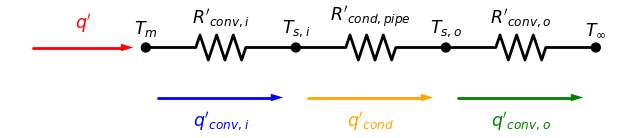

In [344]:
from Libraries import HT_thermal_resistance as res
import schemdraw as schem
import schemdraw.elements as elm

Rp = []
Rp.append(res.Resistance("$R'_{conv,i}$","W/m"))
Rp.append(res.Resistance("$R'_{cond,pipe}$","W/m"))
Rp.append(res.Resistance("$R'_{conv,o}$","W/m"))

with schem.Drawing() as d:
    d += elm.Dot().label("$T_m$")
    d += elm.Resistor().label(Rp[0].name)
    d += elm.Dot().label("$T_{s,i}$")
    d += elm.Resistor().label(Rp[1].name)
    d += elm.Dot().label("$T_{s,o}$")
    d += elm.Resistor().label(Rp[2].name)
    d += elm.Dot().label("$T_{\infty}$")
    d += elm.Line(arrow='->').right().at((-2.25,0)).length(2).label("$q'$").color('red')
    d += elm.Line(arrow='->').right().at((0.25,-1)).length(2.5).label("$q'_{conv,i}$",'bottom').color('blue')
    d += elm.Line(arrow='->').right().at((3.25,-1)).length(2.5).label("$q'_{cond}$",'bottom').color('orange')
    d += elm.Line(arrow='->').right().at((6.25,-1)).length(2.5).label("$q'_{conv,o}$",'bottom').color('green')

In [345]:
from Libraries import thermodynamics as thermo
from Libraries import HT_internal_convection as intconv

k_pipe = 0.15 #W/m.K
Di = 0.15 #m
Do = 0.17 #m
T_infty = 17 #C
h_o = 1500 #W/m^2.K
T_mi = 29 #C
T_mo = 21 #C

Qdot = 0.025 #m^3/s
#T_m defines temperature for thermo prop. in internal flow
T_m = (T_mi + T_mo)/2


airi = thermo.Fluid('air',T_mi,"C") #properties at inlet
airm = thermo.Fluid('air', T_m,"C") # average properties inside pipe
airflow = intconv.PipeFlow(D=Di, L = 1., mdot = airi.rho*Qdot, nu=airm.nu, rho=airm.rho)
# viscosity and density are defined at average temperature
# At this point airflow has calculated the internal Reynolds number
airflow.Dittus_Boelter(mode='cooling',Pr=airm.Pr)

print("Re=%.0f" %airflow.Re)
print("Nu=%.0f" %airflow.Nu)
hbar_i = airflow.Nu*airm.k/Di
print("hbar,i=%.2f W/m^2.K" %hbar_i)
#Compute thermal resistances
Rp[0].convection(hbar_i,np.pi*Di)
Rp[1].cond_cylinder(k = k_pipe,ra=Di,rb=Do,L=1)
Rp[2].convection(h_o,np.pi*Do)

Rptot = Rp[0].R + Rp[1].R + Rp[2].R
    
# def L_given_other_params(T_infty,T_mo,T_mi,mdot,Cp,Rptot):
#     return -mdot*Cp*Rptot*np.log((T_infty -T_mo)/(T_infty - T_mi))
# L = L_given_other_params(T_infty,T_mo,T_mi,airi.rho*Qdot,airm.Cp,Rptot)
L = intconv.L_given_other_params(T_infty,T_mo,T_mi,airi.rho*Qdot,airm.Cp,Rptot)
print("Length needed to achieve T_mo=%.1f C for T_mi= %.1f C and T_inf= %.1f C is %.1f m" %(T_mo,T_mi,T_infty,L))

Re=13446
Nu=42
hbar,i=7.24 W/m^2.K
Length needed to achieve T_mo=21.0 C for T_mi= 29.0 C and T_inf= 17.0 C is 13.8 m


### Pb 2


Hot water at mean temperature $T_m=50\text{$^\circ$C}$ is routed from one building in which it is generated to an adjoining building in which it is used for space heating. Transfer between the buildings occurs in a steel pipe ($k=60\text{ W/m.K}$) of $100 \text{ mm}$ outside diameter and 8-mm wall thickness. During the winter, representative environmental conditions involve air at $T_\infty= -5^\circ \mathrm{C}$ and $V_\infty=3\text{ m/s}$ in cross ﬂow over the pipe.
Using the Churchill Bernstein and Dittus Boehler correlations, calculate the total heat transfer rate <b>per unit length</b> $q'$, the daily energy cost $Q'=q'\times 24\text{ h/d}$ per meter and the cost per day and per meter assuming an electricity cost of $\text{\$}0.05\text{/kW.h}$.

**FYI:** This is the Churchill-Bernstein correlation which you can call with the `from Libraries import HT_external_convection as extconv` `airflow=extconv.CircularCylinder('Churchill-Bernstein',Re,Pr)`
$$
Nu_D = \frac{hD}{k_f}=0.3+\frac{0.62Re_D^{1/2}Pr^{1/3}}{\left[1+\left(\frac{0.4}{Pr}\right)^{2/3}\right]^{1/4}}\left[1+\left(\frac{Re_D}{282,000}\right)^{5/8}\right]^{4/5}
$$

<img src="figures1/problem_2_diagram.png" alt="my awesome sketch" width=100% >

### Solution
Your assumptions and equations:
Assumptions:

<ul>
<li>Steady State 
<li>Uniform properties
<li>One-dimensional heat transfer
<li>Fully developed flow
<li>Iterative calculations performed are considered true
</ul>
Equations:

<ol>
<li>Air and water properties are retrieved using thermodynamic library for the inlet temperature \(T_i\) and the temperature of the internal flow \(T_m\):
   <ul>
   <li>Library is used to get density, Prandtl and Nusselt Number based off from table of air or water properties at different temperatures
   </ul>
<li>PipeFlow class from HT_internal_convection is used to retrieve the Reynolds Number and Nusselt based off from air properties.
<li> Using Nusselt and Reynolds number inital heat transfer coefficient was calculated
$$
\overline{h_{i}} = \frac{Nu * k_{w}}{D_{i}}
$$
<li> Initial guess for Tso is performed and is used to gather air properties for the subsequent reynolds calculations
<li> The Reynolds number was calculated through the following equation and used for the subsequent formulas
$$
Re = \frac{U_{\infty}*D_O}{Nu}
$$  

<li> Using the Reynolds and Nusselt numbers, the external heat transfer coefficient was calculated
$$
h_{ext} = Nu \cdot \frac{k_{air}}{D_O}
$$
<li> Using the above numerical values, the resistances were calculated for the convection in, the conduction of the cylinder, and the convection out:
$$
R_{conv,} = \frac{1}{hA}
$$
$$
R_{cond} = \frac{L}{kA}
$$
<li>Add in the two convective resistances and the on conductive resistance results in the total thermal resistance:
$$
Rp_{tot} = Rp_{conv, 1} + Rp_{cond} + Rp_{conv,2}
$$
<li> The heat transfer can thus be calculated:
$$
qp = \frac{T_m - T_{\infty}}{Rp_{tot}}
$$
<li> Then an updated T_{so} can be calculated using qp, with this iterative testing can be performed to find the temperature T_{so}
$$
T_{so} = T_m - q_p * Rp_{conv,2}
$$
<li> once the final T_{so} value is found the total daily energy loss is determined and then the daily cost as well:
$$
Q_p = qp * 24
$$
$$
Cp = Q_p * 0.05
$$
</ol>

In [346]:
"""
importing the necessary libraries, do not modify
"""
%matplotlib inline 


from IPython.display import clear_output

import schemdraw as schem
import schemdraw.elements as e

import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc

import sympy as sym
Tm = 50  # C
Um = 0.5  # m/s

Di = 0.084  # m
Do = 0.1  # m
kp = 60  # W/m.K

T_infty = -5  # C
U_infty = 3  # m/s

from Libraries import HT_thermal_resistance as res
Rp = []
Rp.append(res.Resistance("$R'_{conv,i}$", "W/m"))
Rp.append(res.Resistance("$R'_{cond,pipe}$", "W/m"))
Rp.append(res.Resistance("$R'_{conv,o}$", "W/m"))

# internal convection
from Libraries import thermodynamics as thermo
from Libraries import HT_internal_convection as intconv

# internal convection
water = thermo.Fluid('water', Tm, 'C')
pipeflow = intconv.PipeFlow(Um=Um, D=Do, nu=water.nu)
print("Re_D_pipe= %.0f" % pipeflow.Re)
pipeflow.Dittus_Boelter(mode='cooling', Pr=water.Pr)
hbar_i = pipeflow.Nu * water.k / Di
print("hbar,i=%.1f W/m^2.K" % hbar_i)
Rp[0].convection(hbar_i, np.pi * Di)
print("REAIR:",Re_air)
# conduction
Rp[1].cond_cylinder(k=kp, ra=Di, rb=Do)

# external convection

# guess for surface temperature at D=Do
T_so = -4.27  # C
T_f = ((Tm + T_infty) / 2)
air = thermo.Fluid('air', T_so, 'C')
Re_air = (U_infty * Do) / air.nu
from Libraries import HT_external_convection as extconv
airflow = extconv.CircularCylinder('Churchill-Bernstein', Re_air, air.Pr)
hext = airflow.Nu * air.k / Do
print("hext=%.1f W/m^2.K" % hext)
Rp[2].convection(hext, np.pi * Do)

# total thermal resistance
Rptot = Rp[0].R + Rp[1].R + Rp[2].R

qp = (Tm - T_infty) / Rptot

print("Heat rate per unit length: %.0f W/m" % qp)

# New estimate of T_so
T_so = Tm - (qp * Rp[2].R )
print("Rptot: %.10f " % Rptot)
print("New T_so = %.2f C" % T_so)



Re_D_pipe= 90336
hbar,i=2376.4 W/m^2.K
REAIR: 23112.92590381171
hext=20.7 W/m^2.K
Heat rate per unit length: 353 W/m
Rptot: 0.1558274635 
New T_so = -4.27 C


In [347]:
Qp = qp * 24
print("Daily energy loss: %.3f kW.h/d/m" %Qp)
Cp = Qp * 0.05
print("Cost: $%.3f /m.d " %Cp)

Daily energy loss: 8470.907 kW.h/d/m
Cost: $423.545 /m.d 


### PB 3
Water at a flow rate or $\dot{m}=0.215\mathrm{kg/s}$ is cooled from $70^\circ\mathrm{C}$ to $30^\circ\mathrm{C}$ by passing it through a thin-walled tube of diameter $D=50\mathrm{mm}$ and maintaining a coolant at $T_\infty=15^\circ\mathrm{C}$ in cross flow over the tube.
* (1) What is the required tube length if the coolant is air and its velocity is $V=20\mathrm{m/s}$
* (2) What is the tube length if the coolant is water and $V=2\mathrm{m/s}$

#### Solution 
Your assumptions and equations here:

Assumptions:
<ul>
<li>Steady State 
<li>Uniform properties
<li>one dimensional heat transfer
<li>0 roughness for pipes
<li>fully developed flow
<li>Curchgill-Benstein is to be used for correlations
 
</ul>
Equations:
<ol>
<li>Air properties are retrieved using thermodynamic library for the inlet Ti and the temperature of the internal flow Tm:
   <ul>
   <li>Library is used to get density, Prandtl and Nusselt Number based off from table of air properties at different temperatures
   <li> Convection heat rate is calculated using mass flow rate, waters Cp caluem and the initial and final fluid temperature.
   </ul>
<li> The followin equations are all based off from the governing energy balance of the convection heat rate:
$$
\dot{Q} = \dot{m} * C_{p} * (T_{m,i}-T_{m,o})
$$
<li>PipeFlow class from HT_internal_convection is used to retrieve the Reynolds Number and Nusselt basedmoff from air properties.
<li> The function internalflow.f_turbulent is used to retrieve the friction coefficient using the Reynolds Number, along with the relative roughness for the pipe.
<li> The Gnielinski correlation was used to determine the Nusselt for the inlet using waters Pr number and Friction coefficient
<li> Thus using the Nusselt number (Nu) the Internal Convection cofficient was calculated and thus the resistance value as well:
$$
hi = \frac{Nu * k_{w}}{D}
$$
<li> The resistance value is determined using the the convection coefficient hi, and the area Pi multiplied by diameter
$$
R_{conv} = \frac{1}{hA}
$$
<li>The convective log mean temperature is then calculated using the log_mean_temperature class in the internal convection livrary, the class took the surounding temperature, inlet temperature, and outlet temperature as inputs and output the mean value.
<li> Then using internal convection library the reynolds number for air when it is the coolant is calculated
<li> Then using Churchill-Bernstein Correlation with air's Reynold number and air's Prandt number the Nusselt number is calculated using the CircularCylinder class in the library.
<li> using the Nusselt number the outlets external convection coefficient was determined:
$$
ho = \frac{Nu * k_{air}}{D}
$$
<li> Then using ho Rp[1] is calculated in the same way as Rp[0]. The two are then added together to get Rp_{total}
<li> Additionally U was calculated (the two convection coefficients dded together)
$$
U = (hi^{-1}+ho^{-1})^{-1}
$$
<li>  using Rp_{total}, U, D, DTlm and pi the length of the pipe was calulated:
$$
L = \frac{qconv}{U * \pi * D * DTlm}
$$
<li> The same process was repeated however instead of using air as the coolent water was used. This din't change the process just the values used.

In [348]:
from Libraries import thermodynamics as thermo
mdot = 0.215 #kg/s
Tmi= 70 #C
Tmo = 30 #C
Tinf = 15 #C
Vair_out = 20 #m/s
Vwater_out = 2 #m/s
D = 0.05 #m




#### Thermal circuit

The thermal circuit of heat transfer from the inner fluid to the outer coolant fluid consists of two convection resistances under the assumptions above:

In [349]:
from Libraries import HT_thermal_resistance as res
R = []
R.append(res.Resistance("$R'_{conv,i}$", "W/m"))
R.append(res.Resistance("$R'_{conv,o}$", "W/m"))


### Overall energy balance (Eq. 9
The overall energy balance determines the convection heat rate (Eq. 9)
$$
\dot{Q} = \dot{m} * C_{p} * (T_{m,i}-T_{m,o})
$$

In [350]:
water = thermo.Fluid('water', 70, 'C')
waterout = thermo.Fluid('water', 15, 'C')
airout = thermo.Fluid('air', 15, 'C')
qconv = mdot * water.Cp * (Tmi - Tmo)
print("Convection heat rate: %.0f W" %qconv)

Convection heat rate: 36035 W


Here write the equation to determine the length of the pipe 

$$
L = \frac{q}{U * \pi*D*\Delta{T_{lm}}}
$$


The internal convection coefficient is calculated using the Gnielinski correlation, the external with Churchill-Bernstein

In [351]:
from Libraries import HT_internal_convection as intconv
from Libraries import HT_external_convection as extconv


internalflow = intconv.PipeFlow(D= D,mdot=mdot, rho=water.rho, nu=water.nu)
internalflow.f_turbulent(Re = internalflow.Re,eps = 0.0)
internalflow.Gnielinski(Pr = water.Pr,f = internalflow.f )
print("Internal convection Nu = %0.1f" %internalflow.Nu)
hi = internalflow.Nu * water.k / D
print("Internal convection coefficient: %.0f W/m^2.K" %hi)
Rp[0].convection(hi, np.pi * D)

DTlm = intconv.log_mean_temperature(T_s=Tinf,T_o=Tmo,T_i=Tmi)


Pipe wall is assumed to be hydrodynamically smooth
Internal convection Nu = 68.9
Internal convection coefficient: 914 W/m^2.K


* (1) For Air:

In [352]:
internalflowairout = intconv.PipeFlow(D= D, Um =Vair_out , nu=airout.nu)
Re_air_out = internalflowairout.Re
externalflow = extconv.CircularCylinder('Churchill-Bernstein',Re= Re_air_out,Pr= airout.Pr)
print("External convection Nu = %0.1f" %internalflow.Nu)
ho = externalflow.Nu * air.k / D

print("External convection coefficient: %.0f W/m^2.K" %ho)
Rp[1].convection(ho, np.pi * D)
Rtot = Rp[0].R + Rp[1].R
U = ((hi)**(-1)+(ho)**(-1))**(-1)
T_lm = ((Tmi-Tinf)-(Tmo-Tinf)) /  math.log((Tmi-Tinf) / (Tmo-Tinf))

L = qconv / (U * np.pi * D * T_lm )
print("For air, L = %.1f m" %L)

External convection Nu = 68.9
External convection coefficient: 80 W/m^2.K
For air, L = 100.9 m


* (2) For Water:

In [353]:
internalflow_water_out = intconv.PipeFlow(D= D, Um =Vwater_out , nu=waterout.nu)
Re_water_out = internalflow_water_out.Re
externalflow = extconv.CircularCylinder('Churchill-Bernstein',Re= Re_water_out,Pr= waterout.Pr)
print("External convection Nu = %0.1f" %internalflow.Nu)
ho = externalflow.Nu * waterout.k / D
print("External convection coefficient: %.0f W/m^2.K" %ho)
R[1].convection(ho, np.pi * D)
Rtot = Rp[0].R + Rp[1].R
U = ((hi)**(-1)+(ho)**(-1))**(-1)
T_lm = ((Tmi-Tinf)-(Tmo-Tinf)) /  math.log((Tmi-Tinf) / (Tmo-Tinf))

L = qconv / (U * np.pi * D * T_lm )

print("For water, L = %.1f m" %L)

External convection Nu = 68.9
External convection coefficient: 5774 W/m^2.K
For water, L = 9.4 m
